## CMSE 381 FINAL PROJECT-TYLER MATSON

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

These are all the imports I am using

In [5]:
bank = pd.read_csv('TaiwanBank.csv')
pm = pd.read_csv('BeijingPM.csv')

I'll be using these two datasets. For the Taiwan Bank dataset, it represents many different variables of each bank in Taiwan, and whether or not those banks went bankrupt. For that classification, I'll be creating an SVM and figuring out which parameters are optimal. It will predict bankruptcy using all of the other variables as input variables. For the BeijingPM dataset, it represents different polution levels of cities at different times. For that regression, I'll be creating a Random Forest Regressor and creating a decision tree with it. It will measure the PM concentration using the other variables as input variables. 

In [6]:
pm

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


Here's what the data looks like, but there are several locations for the polution data, so I am going to see which one has the least amount of null values, and use that one.

In [7]:
print(sum(pd.isnull(pm['PM_Dongsi'])))
print(sum(pd.isnull(pm['PM_Dongsihuan'])))
print(sum(pd.isnull(pm['PM_Nongzhanguan'])))
print(sum(pd.isnull(pm['PM_US Post'])))


27532
32076
27653
2197


In [8]:
pm = pm.drop(columns=['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'month', 'day', 'hour', 'year', 'cbwd'])

Here I am dropping the columns of the unused cities, as well as variables that will not have a negligible effect on the pollution.

In [9]:
pm.dropna(inplace=True)

Dropping any null values

In [10]:
pm.isnull().sum()

No               0
season           0
PM_US Post       0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
dtype: int64

Just ensuring that there is no more null values

In [11]:
pm = pm.rename(columns={"PM_US Post": "PM_US"})

Renaming the columns because it has a space in it and it gets a little messy

In [12]:
pmX = pm.drop(['PM_US'], axis = 1)
pmy = pm.PM_US
pmX.head()

,No,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
23,24,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0
24,25,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0
25,26,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0
26,27,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0
27,28,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0


Separating the values and double checking what it looks like 

In [13]:
pmy

23       129.0
24       148.0
25       159.0
26       181.0
27       138.0
         ...  
52579    133.0
52580    169.0
52581    203.0
52582    212.0
52583    235.0
Name: PM_US, Length: 49579, dtype: float64

In [14]:
pmX.dtypes

No                 int64
season             int64
DEWP             float64
HUMI             float64
PRES             float64
TEMP             float64
Iws              float64
precipitation    float64
Iprec            float64
dtype: object

Ensuring the variables are ready to be used

In [15]:
pmX['Spring'] = np.where(pmX['season'] == 1, 1, 0)
pmX['Summer'] = np.where(pmX['season'] == 2, 1, 0)
pmX['Fall'] = np.where(pmX['season'] == 3, 1, 0)
pmX['Winter'] = np.where(pmX['season'] == 4, 1, 0)
pmX= pmX.drop('season', axis = 1)
pmX= pmX.drop('No', axis = 1)
pmX

,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,Spring,Summer,Fall,Winter
23,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,0,0,0,1
24,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,0,0,0,1
25,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,0,0,0,1
26,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,0,0,0,1
27,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
52579,-8.0,68.0,1031.0,-3.0,7.14,0.0,0.0,0,0,0,1
52580,-8.0,63.0,1030.0,-2.0,8.03,0.0,0.0,0,0,0,1
52581,-10.0,73.0,1030.0,-6.0,0.89,0.0,0.0,0,0,0,1
52582,-10.0,73.0,1030.0,-6.0,1.78,0.0,0.0,0,0,0,1


The season column just gave a variable 1-4 to represent what season it was, and while the season probably has an impact on the polution, it might be hard to see if something like season, a categorical variable, is tied to a quantitative variable, so I made some new columns for each of the seasons. 

In [16]:
pmForest = RandomForestRegressor(max_features = 3, oob_score = True )
pmForest.fit(pmX,pmy)

RandomForestRegressor(max_features=3, oob_score=True)

This is just fitting the random forest. Max features could be increased, but then the diagram gets very small and I know you don't want to have to zoom in to see the values. Additionally, 3 max features gives a decent distribution of each of the leaves of the decision tree. 

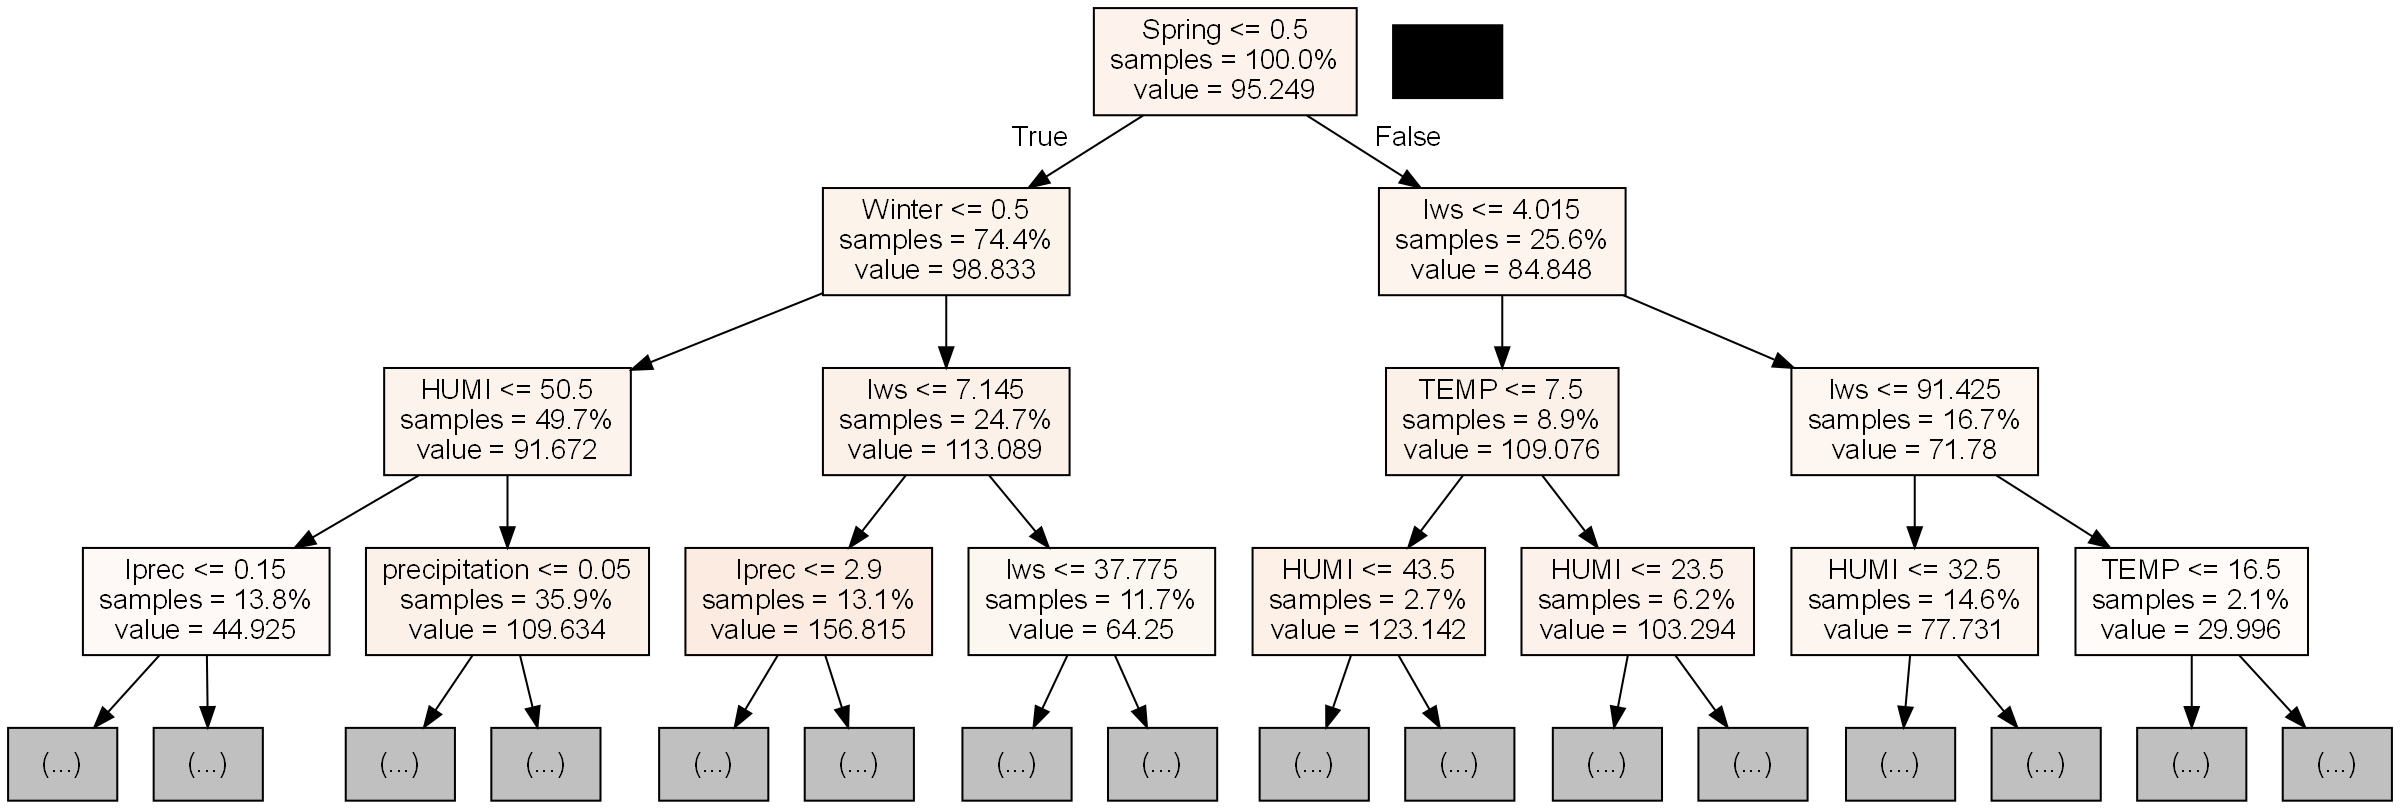

In [17]:

tree = pmForest.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=pmX.columns,  
                            filled=True,  
                            max_depth=3, 
                            impurity=False, 
                            proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())

Here's the random forest visualized. I used graphviz to create the display, and then needed to add an additional package, pydotplus, in order to adjust the size of the display so it fit accordingly to the screen without needing to scroll or zoom. It uses each of the variables to create a good distribution of each of the leaves of the tree, in order to predict the value of the PM polution in the air for each data value. We can see each percentage sample of the values, and the higher values are darker color. 

In [18]:
pred = pmForest.predict(pmX)
mse = mean_squared_error(pmy, pred)
print(mse)

880.4974854323862


MSE is 885, which is good for the given range of values of the PM. 

In [19]:
pmForest = RandomForestRegressor(max_features = 4, oob_score = True )
pmForest.fit(pmX,pmy)
tree = pmForest.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=pmX.columns,  
                            filled=True,  
                            max_depth=4, 
                            impurity=False, 
                            proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())
pred = pmForest.predict(pmX)
mse = mean_squared_error(pmy, pred)
print(mse)

880.1413720649954


In [20]:
pmForest = RandomForestRegressor(max_features = 5, oob_score = True )
pmForest.fit(pmX,pmy)
tree = pmForest.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=pmX.columns,  
                            filled=True,  
                            max_depth=5, 
                            impurity=False, 
                            proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())
pred = pmForest.predict(pmX)
mse = mean_squared_error(pmy, pred)
print(mse)

882.8014534675372


In [21]:
pmForest = RandomForestRegressor(max_features =11, oob_score = True )
pmForest.fit(pmX,pmy)
tree = pmForest.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=pmX.columns,  
                            filled=True,  
                            max_depth=7, 
                            impurity=False, 
                            proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())
pred = pmForest.predict(pmX)
mse = mean_squared_error(pmy, pred)
print(mse)

889.4598956621392


4 Features seems to be optimal with the lowest MSE. 

In [22]:
bank

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


Now onto the banking data set, we can see there are many different variables for each bank, and bankruptcy values 0 for if the bank hasn't gone bankrupt, and 1 if the bank has gone bankrupt. Additionally, I saw the 0 or 1 for the Net Income Flag column and Liability-Assets Flag, so I wanted to explore those more and make sure they had variation. 

In [23]:
print(bank['Bankrupt?'].value_counts()[0])
print(bank[' Net Income Flag'].value_counts()[1])
print(bank[' Liability-Assets Flag'].value_counts()[1])

len(bank)

6599
6819
8


6819

After getting the counts of the Bankruptcy, Net Income Flag, and Liability-Assets Flag column, we can see variation in Bankruptcy and Liability-Assets column, however every bank has a Net Income Flag, so it's not going to be useful in our SVM, so we can safely drop it. 

In [24]:
bank = bank.drop(columns=[' Net Income Flag'])

Dropping the Net Income Flag column. 

In [25]:
bank = bank.rename(columns={"Bankrupt?": "Bankrupt"})
bank

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,0.044009


Renaming the bankruptcy column because a ? in the name makes things messy

In [26]:
banky = bank.Bankrupt.values
bankX= bank.drop('Bankrupt', axis = 1)

Splitting the bank values in to different values 

In [27]:
bankX

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,0.029890
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,0.038284
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,0.097649
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,0.044009


In [28]:
svc = SVC()
svc.fit(bankX,banky)
C_list = [0.001, 0.01, 0.1, 1, 5, 10]
tuned_parameters = [{'C': C_list, 'gamma': C_list}]
clf = GridSearchCV(svc, tuned_parameters, cv=10, scoring='accuracy')
clf.fit(bankX,banky)
clf.best_params_

{'C': 0.001, 'gamma': 0.001}

This is finding the optimal parameters for the SVM.

In [29]:
svc = SVC(C=.001, gamma = .001)
svc.fit(bankX,banky)

SVC(C=0.001, gamma=0.001)

In [30]:
yhat = svc.predict(bankX)

In [31]:
mse = mean_squared_error(banky, yhat)
print(mse)

0.03226279513125092


Very low MSE, most likely because there are so many input variables. 

In conclusion, here is an accurate classification predictor using an SVC, and an accurate regression predictor using Random Forests Regression and a decision tree. 